In [1]:
!export PYTORCH_ENABLE_MPS=0

In [4]:
!export PYTORCH_ENABLE_MPS_FALLBACK=0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "u8darts[all]"
!pip install optuna

In [ ]:
import pandas as pd
import optuna
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel
from darts.metrics import mape, mae
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
df = pd.read_csv("drive/MyDrive/hse_diploma/data_after_selection.csv")
del df["Unnamed: 0"]
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df = df.sort_index()
df = df.asfreq('MS')
df.reset_index(drop=False, inplace=True)

In [ ]:
# Целевой ряд
target_series = TimeSeries.from_dataframe(df, 'time', 'inflation_rate')

# Экзогенные переменные
exog_vars = [col for col in df.columns if col not in ['time', 'inflation_rate']]
exog_series = TimeSeries.from_dataframe(df, 'time', exog_vars)

scaler_target = Scaler()
scaler_exog = Scaler()

target_series_scaled = scaler_target.fit_transform(target_series)
exog_series_scaled = scaler_exog.fit_transform(exog_series)

forecast_horizon = 6

train_val_target = target_series_scaled[:-forecast_horizon]
test_target = target_series_scaled[-forecast_horizon:]

train_val_exog = exog_series_scaled[:-forecast_horizon]
test_exog = exog_series_scaled[-forecast_horizon:]


train_target = train_val_target[:-forecast_horizon]
val_target = train_val_target[-forecast_horizon:]

train_exog = train_val_exog[:-forecast_horizon]
val_exog = train_val_exog[-forecast_horizon:]

In [9]:
import logging
import optuna
logging.basicConfig(level=logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.WARNING)

In [ ]:
def objective(trial):

    hidden_size = trial.suggest_int("hidden_size", 25, 750, step = 25)
    n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    n_epochs = 100

    torch.manual_seed(42)   # reproducibility
    NR_EPOCHS_VAL_PERIOD = 1

    early_stopper = EarlyStopping(monitor="train_loss", min_delta=0.0005, patience=5, verbose=False)
    callbacks = [early_stopper]

    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "callbacks": callbacks,
            'enable_progress_bar': True,
        }
        num_workers = 2
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    model = BlockRNNModel(
        model="LSTM",
        input_chunk_length=12,
        output_chunk_length=6,
        hidden_dim=hidden_size,
        n_rnn_layers=n_rnn_layers,
        dropout=dropout,
        batch_size=batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={"lr": 1e-3},
        model_name=f"lstm_optuna_trial",
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        pl_trainer_kwargs=pl_trainer_kwargs,
        random_state=42
    )

    model.fit(series=train_target, past_covariates=train_exog, verbose=False)

    forecast_scaled = model.predict(n=len(val_target), series=train_target, past_covariates=train_exog, verbose=False)

    forecast = scaler_target.inverse_transform(forecast_scaled)
    error = mape(target_series, forecast, intersect=True)

    print(f"Trial {trial.number} — MAPE: {error:.4f}, params: hidden_size={hidden_size}, layers={n_rnn_layers}, dropout={dropout:.2f}, batch_size={batch_size}")

    return error

study = optuna.create_study(direction="minimize", study_name="LSTM_inflation_opt")

study.optimize(objective, n_trials=500, show_progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Trial 0 — MAPE: 69.3909, params: hidden_size=700, layers=2, dropout=0.45, batch_size=32
Trial 1 — MAPE: 109.5720, params: hidden_size=275, layers=2, dropout=0.33, batch_size=64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2826971253510139 and num_layers=1
  warnings.warn(


Trial 2 — MAPE: 116.6097, params: hidden_size=175, layers=1, dropout=0.28, batch_size=32
Trial 3 — MAPE: 70.9174, params: hidden_size=425, layers=2, dropout=0.20, batch_size=32
Trial 4 — MAPE: 93.3359, params: hidden_size=625, layers=2, dropout=0.10, batch_size=16
Trial 5 — MAPE: 23.6949, params: hidden_size=275, layers=2, dropout=0.41, batch_size=16
Trial 6 — MAPE: 71.3306, params: hidden_size=450, layers=2, dropout=0.28, batch_size=64


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4574363656806969 and num_layers=1
  warnings.warn(


Trial 7 — MAPE: 75.6023, params: hidden_size=750, layers=1, dropout=0.46, batch_size=64
Trial 8 — MAPE: 151.8326, params: hidden_size=300, layers=3, dropout=0.25, batch_size=32
Trial 9 — MAPE: 111.3019, params: hidden_size=575, layers=2, dropout=0.33, batch_size=64
Trial 10 — MAPE: 107.5265, params: hidden_size=25, layers=3, dropout=0.01, batch_size=16
Trial 11 — MAPE: 62.6956, params: hidden_size=175, layers=3, dropout=0.49, batch_size=16
Trial 12 — MAPE: 92.4692, params: hidden_size=125, layers=3, dropout=0.49, batch_size=16
Trial 13 — MAPE: 161.3283, params: hidden_size=275, layers=3, dropout=0.40, batch_size=16


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40288904292688726 and num_layers=1
  warnings.warn(


Trial 14 — MAPE: 93.3867, params: hidden_size=150, layers=1, dropout=0.40, batch_size=16
Trial 15 — MAPE: 113.8138, params: hidden_size=25, layers=3, dropout=0.39, batch_size=16
Trial 16 — MAPE: 132.1670, params: hidden_size=350, layers=2, dropout=0.18, batch_size=16
Trial 17 — MAPE: 80.0599, params: hidden_size=200, layers=3, dropout=0.36, batch_size=16


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4873712022134199 and num_layers=1
  warnings.warn(


Trial 18 — MAPE: 108.0403, params: hidden_size=525, layers=1, dropout=0.49, batch_size=16
Trial 19 — MAPE: 154.3340, params: hidden_size=225, layers=2, dropout=0.43, batch_size=16
Trial 20 — MAPE: 135.8848, params: hidden_size=100, layers=3, dropout=0.49, batch_size=16
Trial 21 — MAPE: 105.3825, params: hidden_size=750, layers=2, dropout=0.44, batch_size=32
Trial 22 — MAPE: 82.1851, params: hidden_size=650, layers=2, dropout=0.37, batch_size=32
Trial 23 — MAPE: 75.8002, params: hidden_size=375, layers=2, dropout=0.44, batch_size=32
Trial 24 — MAPE: 85.2262, params: hidden_size=475, layers=2, dropout=0.45, batch_size=32


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.49995193960506157 and num_layers=1
  warnings.warn(


Trial 25 — MAPE: 107.9817, params: hidden_size=325, layers=1, dropout=0.50, batch_size=32
Trial 26 — MAPE: 49.2100, params: hidden_size=225, layers=3, dropout=0.32, batch_size=16
Trial 27 — MAPE: 56.1155, params: hidden_size=225, layers=3, dropout=0.32, batch_size=16
Trial 28 — MAPE: 117.6002, params: hidden_size=250, layers=3, dropout=0.31, batch_size=16
Trial 29 — MAPE: 51.9128, params: hidden_size=225, layers=3, dropout=0.22, batch_size=16
Trial 30 — MAPE: 92.2958, params: hidden_size=75, layers=3, dropout=0.20, batch_size=16
Trial 31 — MAPE: 53.9560, params: hidden_size=225, layers=3, dropout=0.24, batch_size=16
Trial 32 — MAPE: 111.1123, params: hidden_size=325, layers=3, dropout=0.14, batch_size=16
Trial 33 — MAPE: 151.5452, params: hidden_size=250, layers=3, dropout=0.24, batch_size=16
Trial 34 — MAPE: 116.1529, params: hidden_size=400, layers=3, dropout=0.25, batch_size=64
Trial 35 — MAPE: 89.8573, params: hidden_size=175, layers=3, dropout=0.29, batch_size=16
Trial 36 — MAPE: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2662256402191476 and num_layers=1
  warnings.warn(


Trial 52 — MAPE: 83.2659, params: hidden_size=300, layers=1, dropout=0.27, batch_size=16
Trial 53 — MAPE: 120.2819, params: hidden_size=350, layers=2, dropout=0.30, batch_size=16
Trial 54 — MAPE: 42.1403, params: hidden_size=300, layers=2, dropout=0.36, batch_size=16
Trial 55 — MAPE: 91.5110, params: hidden_size=400, layers=2, dropout=0.41, batch_size=16


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33632333335937226 and num_layers=1
  warnings.warn(


Trial 56 — MAPE: 66.3189, params: hidden_size=250, layers=1, dropout=0.34, batch_size=16
Trial 57 — MAPE: 21.6737, params: hidden_size=275, layers=2, dropout=0.31, batch_size=16
Trial 58 — MAPE: 141.9215, params: hidden_size=425, layers=2, dropout=0.05, batch_size=16
Trial 59 — MAPE: 118.9647, params: hidden_size=275, layers=2, dropout=0.36, batch_size=16


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26194487217967805 and num_layers=1
  warnings.warn(


Trial 60 — MAPE: 52.4870, params: hidden_size=350, layers=1, dropout=0.26, batch_size=32
Trial 61 — MAPE: 125.5342, params: hidden_size=325, layers=2, dropout=0.31, batch_size=16
Trial 62 — MAPE: 25.2053, params: hidden_size=300, layers=2, dropout=0.28, batch_size=16
Trial 63 — MAPE: 113.3010, params: hidden_size=200, layers=2, dropout=0.39, batch_size=16
Trial 64 — MAPE: 135.4527, params: hidden_size=250, layers=2, dropout=0.31, batch_size=16
Trial 65 — MAPE: 101.5765, params: hidden_size=275, layers=2, dropout=0.33, batch_size=16
Trial 66 — MAPE: 120.6619, params: hidden_size=375, layers=2, dropout=0.28, batch_size=16
Trial 67 — MAPE: 136.1697, params: hidden_size=350, layers=2, dropout=0.47, batch_size=16
Trial 68 — MAPE: 114.5584, params: hidden_size=325, layers=2, dropout=0.23, batch_size=64
Trial 69 — MAPE: 88.1780, params: hidden_size=150, layers=2, dropout=0.34, batch_size=32
Trial 70 — MAPE: 137.1365, params: hidden_size=250, layers=2, dropout=0.26, batch_size=16
Trial 71 — MA

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36033576719026816 and num_layers=1
  warnings.warn(


Trial 93 — MAPE: 83.9127, params: hidden_size=350, layers=1, dropout=0.36, batch_size=16
Trial 94 — MAPE: 13.4711, params: hidden_size=300, layers=3, dropout=0.30, batch_size=16
Trial 95 — MAPE: 78.3396, params: hidden_size=275, layers=3, dropout=0.30, batch_size=16
Trial 96 — MAPE: 102.9803, params: hidden_size=325, layers=3, dropout=0.28, batch_size=16
Trial 97 — MAPE: 63.1452, params: hidden_size=375, layers=3, dropout=0.30, batch_size=16
Trial 98 — MAPE: 156.4041, params: hidden_size=250, layers=3, dropout=0.33, batch_size=16
Trial 99 — MAPE: 115.1435, params: hidden_size=725, layers=3, dropout=0.47, batch_size=16
Trial 100 — MAPE: 38.2823, params: hidden_size=300, layers=3, dropout=0.31, batch_size=64
Trial 101 — MAPE: 98.2945, params: hidden_size=300, layers=3, dropout=0.32, batch_size=64
Trial 102 — MAPE: 50.0279, params: hidden_size=275, layers=3, dropout=0.26, batch_size=64
Trial 103 — MAPE: 20.0189, params: hidden_size=350, layers=3, dropout=0.29, batch_size=64
Trial 104 — MA

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2097271495422368 and num_layers=1
  warnings.warn(


Trial 250 — MAPE: 84.2396, params: hidden_size=50, layers=1, dropout=0.21, batch_size=64
Trial 251 — MAPE: 16.4921, params: hidden_size=375, layers=3, dropout=0.20, batch_size=64
Trial 252 — MAPE: 44.1461, params: hidden_size=325, layers=3, dropout=0.24, batch_size=64
Trial 253 — MAPE: 17.9373, params: hidden_size=350, layers=3, dropout=0.23, batch_size=64
Trial 254 — MAPE: 17.7488, params: hidden_size=375, layers=3, dropout=0.19, batch_size=64
Trial 255 — MAPE: 128.7254, params: hidden_size=400, layers=3, dropout=0.20, batch_size=64
Trial 256 — MAPE: 112.3905, params: hidden_size=675, layers=3, dropout=0.22, batch_size=64
Trial 257 — MAPE: 20.3184, params: hidden_size=375, layers=3, dropout=0.23, batch_size=64
Trial 258 — MAPE: 15.9515, params: hidden_size=350, layers=3, dropout=0.19, batch_size=64
Trial 259 — MAPE: 16.5829, params: hidden_size=375, layers=3, dropout=0.20, batch_size=64
Trial 260 — MAPE: 124.0180, params: hidden_size=400, layers=3, dropout=0.21, batch_size=64
Trial 26

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1947283034439997 and num_layers=1
  warnings.warn(


Trial 319 — MAPE: 92.1018, params: hidden_size=600, layers=1, dropout=0.19, batch_size=64
Trial 320 — MAPE: 127.4823, params: hidden_size=400, layers=3, dropout=0.21, batch_size=64
Trial 321 — MAPE: 22.9044, params: hidden_size=375, layers=3, dropout=0.24, batch_size=64
Trial 322 — MAPE: 16.4782, params: hidden_size=350, layers=3, dropout=0.17, batch_size=64
Trial 323 — MAPE: 40.5582, params: hidden_size=325, layers=3, dropout=0.22, batch_size=64
Trial 324 — MAPE: 129.3264, params: hidden_size=400, layers=3, dropout=0.20, batch_size=64
Trial 325 — MAPE: 16.9001, params: hidden_size=375, layers=3, dropout=0.23, batch_size=64
Trial 326 — MAPE: 75.0003, params: hidden_size=375, layers=3, dropout=0.21, batch_size=16
Trial 327 — MAPE: 15.6826, params: hidden_size=350, layers=3, dropout=0.19, batch_size=64
Trial 328 — MAPE: 146.2291, params: hidden_size=400, layers=3, dropout=0.30, batch_size=32
Trial 329 — MAPE: 41.0626, params: hidden_size=325, layers=3, dropout=0.22, batch_size=64
Trial 3

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20669104393021426 and num_layers=1
  warnings.warn(


Trial 380 — MAPE: 83.9626, params: hidden_size=375, layers=1, dropout=0.21, batch_size=64
Trial 381 — MAPE: 19.2949, params: hidden_size=350, layers=3, dropout=0.25, batch_size=64
Trial 382 — MAPE: 105.0270, params: hidden_size=400, layers=3, dropout=0.31, batch_size=64
Trial 383 — MAPE: 14.6477, params: hidden_size=375, layers=3, dropout=0.22, batch_size=64
Trial 384 — MAPE: 15.0089, params: hidden_size=375, layers=3, dropout=0.22, batch_size=64
Trial 385 — MAPE: 95.0116, params: hidden_size=425, layers=3, dropout=0.26, batch_size=64
Trial 386 — MAPE: 24.6754, params: hidden_size=350, layers=3, dropout=0.48, batch_size=64
Trial 387 — MAPE: 103.6732, params: hidden_size=375, layers=3, dropout=0.22, batch_size=16
Trial 388 — MAPE: 127.7624, params: hidden_size=400, layers=3, dropout=0.17, batch_size=64
Trial 389 — MAPE: 100.8477, params: hidden_size=750, layers=3, dropout=0.20, batch_size=64
Trial 390 — MAPE: 43.4039, params: hidden_size=325, layers=3, dropout=0.23, batch_size=64
Trial 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2399127398419449 and num_layers=1
  warnings.warn(


Trial 447 — MAPE: 65.4753, params: hidden_size=200, layers=1, dropout=0.24, batch_size=64
Trial 448 — MAPE: 84.9943, params: hidden_size=300, layers=3, dropout=0.22, batch_size=64
Trial 449 — MAPE: 87.5149, params: hidden_size=125, layers=3, dropout=0.20, batch_size=16
Trial 450 — MAPE: 97.2731, params: hidden_size=725, layers=3, dropout=0.23, batch_size=64
Trial 451 — MAPE: 122.6654, params: hidden_size=400, layers=3, dropout=0.21, batch_size=64
Trial 452 — MAPE: 16.7533, params: hidden_size=375, layers=3, dropout=0.19, batch_size=64
Trial 453 — MAPE: 96.6680, params: hidden_size=425, layers=3, dropout=0.20, batch_size=64
Trial 454 — MAPE: 14.9389, params: hidden_size=375, layers=3, dropout=0.22, batch_size=64
Trial 455 — MAPE: 16.8314, params: hidden_size=350, layers=3, dropout=0.22, batch_size=64
Trial 456 — MAPE: 136.4480, params: hidden_size=400, layers=3, dropout=0.24, batch_size=16
Trial 457 — MAPE: 14.9885, params: hidden_size=375, layers=3, dropout=0.22, batch_size=64
Trial 45

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2273231752159029 and num_layers=1
  warnings.warn(


Trial 484 — MAPE: 130.4420, params: hidden_size=400, layers=1, dropout=0.23, batch_size=16
Trial 485 — MAPE: 20.5997, params: hidden_size=350, layers=3, dropout=0.31, batch_size=64
Trial 486 — MAPE: 14.9366, params: hidden_size=375, layers=3, dropout=0.22, batch_size=64
Trial 487 — MAPE: 44.0746, params: hidden_size=325, layers=3, dropout=0.24, batch_size=64
Trial 488 — MAPE: 16.1000, params: hidden_size=375, layers=3, dropout=0.25, batch_size=64
Trial 489 — MAPE: 127.1049, params: hidden_size=350, layers=3, dropout=0.23, batch_size=32
Trial 490 — MAPE: 82.9045, params: hidden_size=300, layers=3, dropout=0.22, batch_size=64
Trial 491 — MAPE: 123.0517, params: hidden_size=400, layers=3, dropout=0.23, batch_size=64
Trial 492 — MAPE: 76.0442, params: hidden_size=375, layers=3, dropout=0.21, batch_size=16
Trial 493 — MAPE: 18.0694, params: hidden_size=350, layers=3, dropout=0.23, batch_size=64
Trial 494 — MAPE: 15.5537, params: hidden_size=375, layers=3, dropout=0.22, batch_size=64
Trial 4

In [11]:
print("Лучшие параметры:")
print(study.best_params)
print(study.best_value)

Лучшие параметры:
{'hidden_size': 300, 'n_rnn_layers': 3, 'dropout': 0.2157042427664935, 'batch_size': 16}
8.896193337894688


**Validation**

In [10]:
#best_params = study.best_params
best_params = {'hidden_size': 300, 'n_rnn_layers': 3, 'dropout': 0.2157042427664935, 'batch_size': 16}

torch.manual_seed(42)
NR_EPOCHS_VAL_PERIOD = 1
early_stopper = EarlyStopping(monitor="train_loss", min_delta=0.0005, patience=5, verbose=False)
callbacks = [early_stopper]

if torch.cuda.is_available():
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "callbacks": callbacks,
        'enable_progress_bar': True,
    }
    num_workers = 2
else:
    pl_trainer_kwargs = {"callbacks": callbacks}
    num_workers = 0


best_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=12,
    output_chunk_length=6,
    hidden_dim=best_params["hidden_size"],
    n_rnn_layers=best_params["n_rnn_layers"],
    dropout=best_params["dropout"],
    batch_size=best_params["batch_size"],
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="lstm_best_model",
    nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
    pl_trainer_kwargs=pl_trainer_kwargs,
    random_state=42
)

best_model.fit(series=train_target, past_covariates=train_exog, verbose=True)
forecast_scaled = best_model.predict(n=len(val_target), series=train_target, past_covariates=train_exog, verbose=True)
forecast_val = scaler_target.inverse_transform(forecast_scaled)
forecast_val_series = forecast_val.to_series()
smoothed_forecast_val_series = forecast_val_series.rolling(window=2, min_periods=0).mean()
smoothed_forecast_val_series = smoothed_forecast_val_series.round(1)
smoothed_forecast_val = TimeSeries.from_series(smoothed_forecast_val_series)

error_mape = mape(target_series, smoothed_forecast_val, intersect=True)
error_mae = mae(target_series, smoothed_forecast_val, intersect=True)

print(f"MAE на валидационной выборке: {error_mae:.2f}")
print(f"MAPE на валидационной выборке: {error_mape:.1f}")

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAE на валидационной выборке: 0.17
MAPE на валидационной выборке: 6.8


**Test**

In [11]:
#best_params = study.best_params
best_params = {'hidden_size': 300, 'n_rnn_layers': 3, 'dropout': 0.2157042427664935, 'batch_size': 16}

torch.manual_seed(42)
NR_EPOCHS_VAL_PERIOD = 1
early_stopper = EarlyStopping(monitor="train_loss", min_delta=0.0005, patience=5, verbose=False)
callbacks = [early_stopper]

if torch.cuda.is_available():
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "callbacks": callbacks,
        'enable_progress_bar': True,
    }
    num_workers = 2
else:
    pl_trainer_kwargs = {"callbacks": callbacks}
    num_workers = 0


best_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=12,
    output_chunk_length=6,
    hidden_dim=best_params["hidden_size"],
    n_rnn_layers=best_params["n_rnn_layers"],
    dropout=best_params["dropout"],
    batch_size=best_params["batch_size"],
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="lstm_best_model",
    nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
    pl_trainer_kwargs=pl_trainer_kwargs,
    random_state=42
)

best_model.fit(series=train_val_target, past_covariates=train_val_exog, verbose=True)
forecast_scaled = best_model.predict(n=len(val_target), series=train_val_target, past_covariates=train_val_exog, verbose=True)
forecast_test = scaler_target.inverse_transform(forecast_scaled)
forecast_test_series = forecast_test.to_series()
smoothed_forecast_test_series = forecast_test_series.rolling(window=2, min_periods=0).mean()
smoothed_forecast_test_series = smoothed_forecast_test_series.round(1)
smoothed_forecast_test = TimeSeries.from_series(smoothed_forecast_test_series)

error_mape = mape(target_series, smoothed_forecast_test, intersect=True)
error_mae = mae(target_series, smoothed_forecast_test, intersect=True)

print(f"MAE на тестовой выборке: {error_mae:.2f}")
print(f"MAPE на тестовой выборке: {error_mape:.1f}")

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAE на тестовой выборке: 0.28
MAPE на тестовой выборке: 10.8


**Визуализация**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
dataset_for_vizual = df[["time", "inflation_rate"]].copy()
smoothed_forecast_val_frame = pd.DataFrame(smoothed_forecast_val_series)
smoothed_forecast_val_frame.rename(columns={"inflation_rate":"inflation_rate_val"}, inplace=True)
smoothed_forecast_test_frame = pd.DataFrame(smoothed_forecast_test_series)
smoothed_forecast_test_frame.rename(columns={"inflation_rate":"inflation_rate_test"}, inplace=True)
dataset_for_vizual = dataset_for_vizual.join(smoothed_forecast_val_frame, on="time", how="left").join(smoothed_forecast_test_frame, on="time", how="left")
dataset_for_vizual.set_index("time", inplace=True)
dataset_for_vizual.tail(10)

,inflation_rate,inflation_rate_val,inflation_rate_test
time,,,
2024-07-01,3.0,3.0,NaN
2024-08-01,2.9,2.9,NaN
2024-09-01,2.5,2.9,NaN
2024-10-01,2.4,3.0,NaN
2024-11-01,2.6,NaN,2.9
2024-12-01,2.7,NaN,2.8
2025-01-01,2.9,NaN,2.7
2025-02-01,3.0,NaN,2.7
2025-03-01,2.8,NaN,2.9


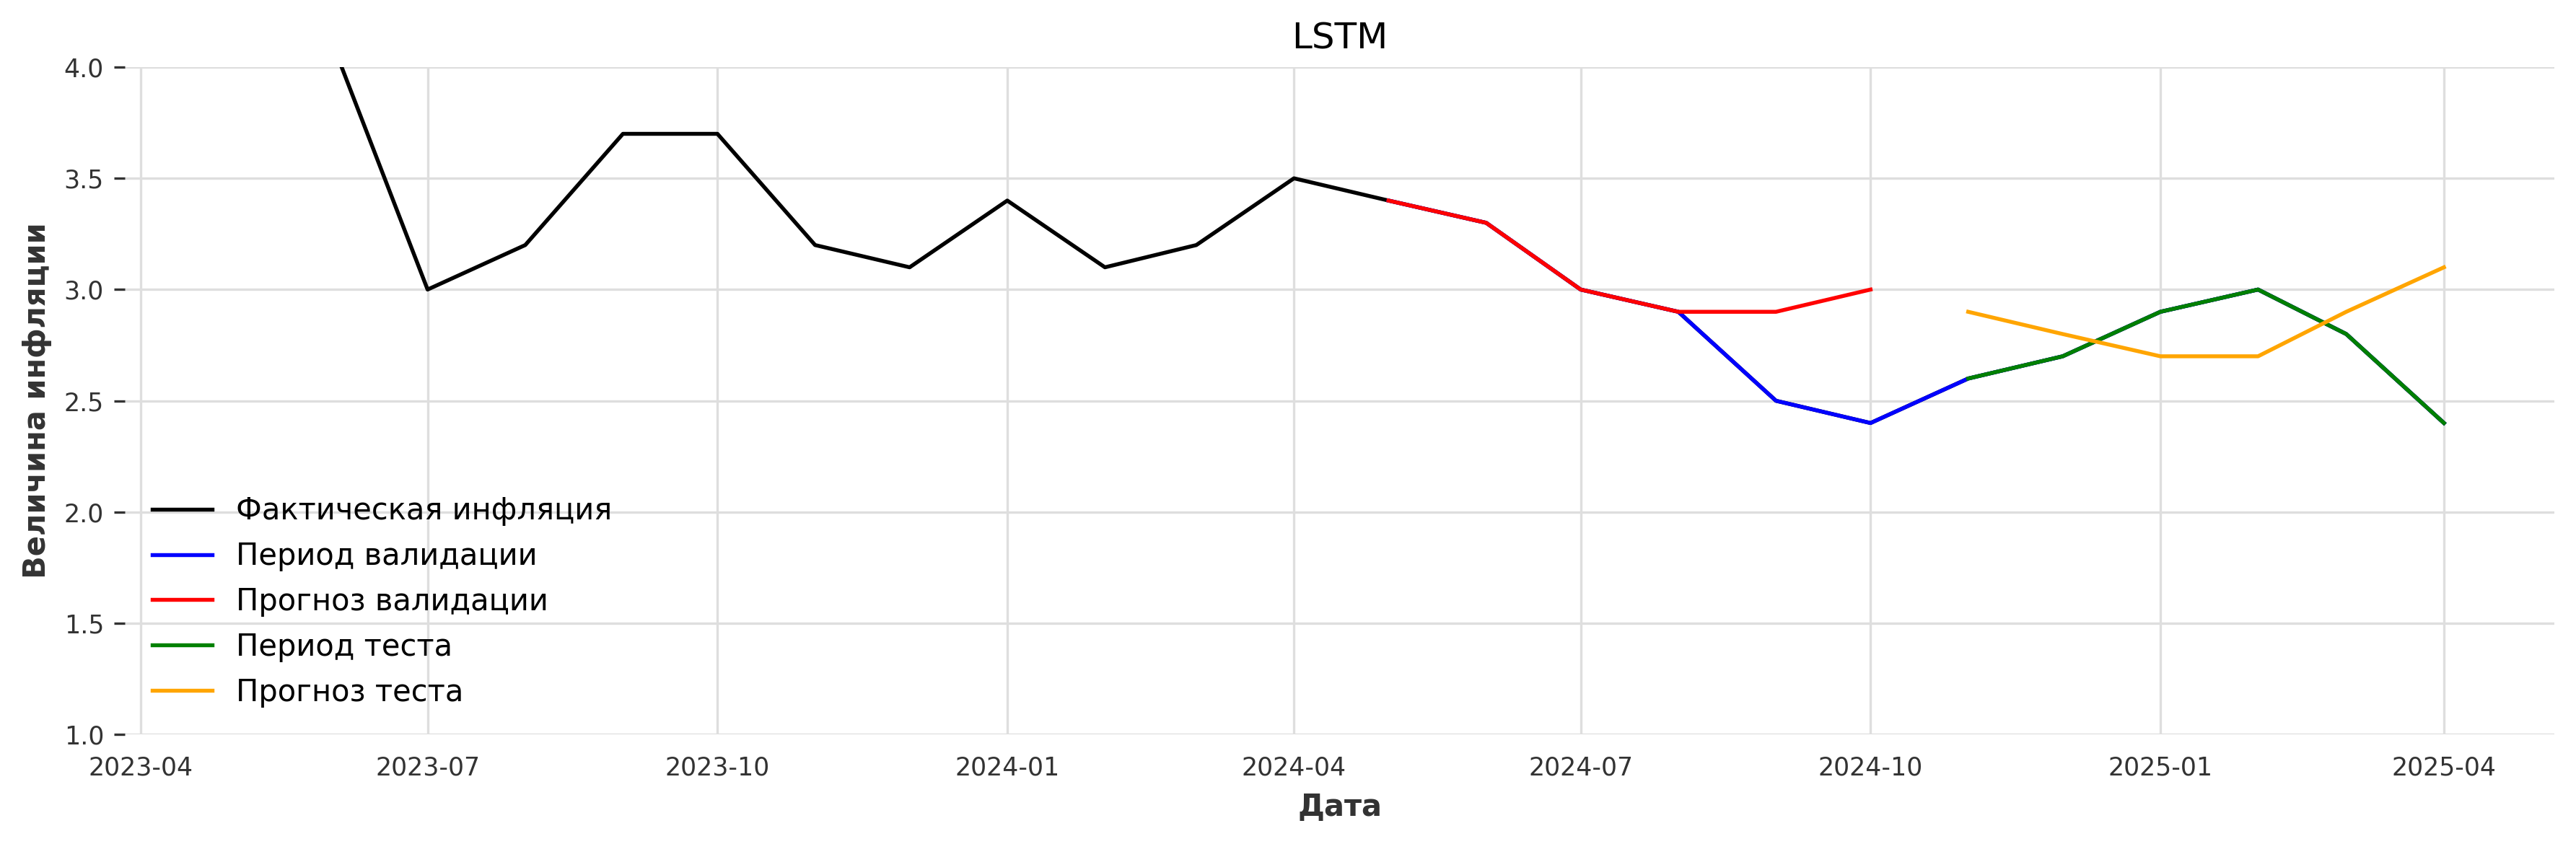

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(12, 4), dpi=300)

sns.lineplot(data=dataset_for_vizual.iloc[-4*forecast_horizon:],
             x=dataset_for_vizual.iloc[-4*forecast_horizon:].index,
             y='inflation_rate',
             label='Фактическая инфляция',
             color="black")

sns.lineplot(data=dataset_for_vizual.iloc[-2*forecast_horizon:],
             x=dataset_for_vizual.iloc[-2*forecast_horizon:].index,
             y='inflation_rate',
             label='Период валидации',
             color="blue")
sns.lineplot(data=dataset_for_vizual.iloc[-2*forecast_horizon:],
             x=dataset_for_vizual.iloc[-2*forecast_horizon:].index,
             y='inflation_rate_val',
             label='Прогноз валидации',
             color="red")

sns.lineplot(data=dataset_for_vizual.iloc[-forecast_horizon:],
             x=dataset_for_vizual.iloc[-forecast_horizon:].index,
             y='inflation_rate',
             label='Период теста',
             color="green")

sns.lineplot(data=dataset_for_vizual.iloc[-forecast_horizon:],
             x=dataset_for_vizual.iloc[-forecast_horizon:].index,
             y='inflation_rate_test',
             label='Прогноз теста',
             color="orange")

plt.xlabel('Дата')
plt.ylabel('Величина инфляции')
plt.title("LSTM")
plt.ylim(1, 4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("drive/MyDrive/hse_diploma/lstm.png", dpi=300)

In [21]:
with open('features_list.txt', 'w', encoding='utf-8') as f:
    for item in df.columns.values:
        f.write(item + '\n')

In [20]:
df.columns.values

array(['time', 'value__quantile__q_0_3__housing_index__6M',
       'value__quantile__q_0_2__housing_index__6M',
       'value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"__housing_index__6M',
       'value__cwt_coefficients__coeff_2__w_5__widths_2_5_10_20__housing_index__6M',
       'value__cwt_coefficients__coeff_0__w_10__widths_2_5_10_20__housing_index__6M',
       'value__linear_trend__attr_"intercept"__housing_index__6M',
       'value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"__housing_index__6M',
       'value__quantile__q_0_1__housing_index__6M',
       'value__cwt_coefficients__coeff_1__w_10__widths_2_5_10_20__housing_index__6M',
       'value__median__housing_index__6M',
       'value__cwt_coefficients__coeff_1__w_5__widths_2_5_10_20__housing_index__6M',
       'value__cwt_coefficients__coeff_2__w_10__widths_2_5_10_20__housing_index__6M',
       'value__cwt_coefficients__coeff_0__w_20__widths_2_5_10_20__housing_index__6M',
       'value__qu